In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

In [3]:
import datetime
import numpy as np
import pandas as pd
from copy import deepcopy
from datetime import datetime as dt
from sklearn.cluster import KMeans
#from settings.setting_dicts import *
#from indicators import indicator_main
#from utilities import date_time_tools
#from settings.setting_dicts import indicators_dict

#from utilities.data_connections import trade_minute_trade_data
#from stat_tools import distplot
#from utilities.date_time_tools import *
#from utilities import preprocess, date_time_tools

#from stat_tools.kernel_distributions import *

#from data.data_class import TradeData
from copy import deepcopy

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import statsmodels.api as sm

#import matplotlib.pyplot as plt
#plt.ioff()

/Users/yesterdays/Downloads/DjangoPython_v3/trading_django/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
def dist_plot(series,
              num_bins = 30,
              bandwidth = None,
              kernel = 'epa',
              show = True,
              save = True,
              gif_frame = False,
              gif_frame_num = '',
              extraplots = True,
              preprocess_bool = True,
              cut = 3,
              adj = 1,
              fixed_x_axis = None,
              close = False):

    if not save and not show :
        print('WARNING: Note that plot will neither be saved nor shown')

    if preprocess_bool:
        if 'numpy.ndarray' in str(type(series)):
            data = series[~np.isnan(series)]
        else:
            data = standarddize_data(series)
    else:
        data = series
    # x_grid = np.linspace(np.min(data), np.max(data), num_bins)

    kde2 = KDEUnivariate_kernel(data, kernel = kernel, adj = adj, cut = cut)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    ax.hist(data, bins=num_bins, normed=True, color='red', alpha = 0.6)
    if fixed_x_axis is not None:
        ax.set_xlim(0, fixed_x_axis)
    ax.plot(kde2.support, kde2.density, lw=2, color='black')

    try:
        name_series = series.name
    except:
        name_series = 'series'

    fig.suptitle('Kernel distribution of ' + name_series + ' using ' + str(kernel) + ' kernel')

    if save:
        if gif_frame:
            datetime_stamp = dt.now().strftime(' %Y-%m-%d')
            fig.savefig('plots/gif/DensityPlot ' + name_series + datetime_stamp + 
                        'frame' + str(gif_frame_num) + '.png')
        else:
            datetime_stamp = dt.now().strftime(' %Y-%m-%d %H%M%S')
            fig.savefig('plots/DensityPlot ' + name_series + datetime_stamp)
    if show:
        fig.show()

    if close:
        fig.clf()

def generate_gif(df_indicator_from_ACD):
    # df_indicator_from_ACD = AnalysisClassDay.dict_of_indicator_df['highlow_vola']

    for col in df_indicator_from_ACD.columns:
        # col = df_indicator_from_ACD.columns[0]

        vector_indicator = np.array(df_indicator_from_ACD[col])

        try:
            dist_plot(vector_indicator, cut=0, adj=3, preprocess_bool=True, gif_frame=True, 
                      gif_frame_num=col, show = False, fixed_x_axis = 0.01 )
        except Exception as theerror:
            logmessage = 'could not create plot %s ' %col + 'due to: ' + str(theerror)
            print logmessage
            print vector_indicator

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-4-ce5c557288a3>, line 75)

In [9]:
def KDEUnivariate_kernel(data, kernel = 'epa', bandwidth = "normal_reference", adj = 1, cut = 3):

    if np.min(data) > 0 and cut != 0:
        print('WARNING: postive only data with non-zero cut')

    if kernel == 'gau':
        usefft = True
    else:
        usefft = False

    kde2 = sm.nonparametric.KDEUnivariate(data)
    kde2.fit(kernel=kernel, fft=usefft, bw=bandwidth, cut = cut, adjust = adj)

    return kde2

In [10]:

local_data_location = '.../data/datasets/'
pd.options.mode.chained_assignment = None  # default='warn'

In [11]:

datasources_dict = {
    'EX_minute_2016': { 'local_dataset' : True,
                        'filename' : 'EX#C-Minute-Trade.csv',
                        'filename_fx': 'DOLLAR INDEX MINUTE TRADE.csv',
                       }
}

# Date and times to use
datetime_setting_dict = {
    'all_time' : {'truncate_time_to_ams' : False,
                 'include_post_close_trades' : True},
    'default': {'truncate_time_to_ams': True,
                'include_post_close_trades': True}
}

# How to preprocess data
preprocess_setting_dict = { # No data yet for these
    'default' : {'correct_for_fx' : False,
                 'exclude_fed_days' : False},
    'non_fx_corrected': {'correct_for_fx': False,
                'exclude_fed_days': False}
}


indicators_dict = {
    'default': {
        'volume_rollingmedian' :
            {'window_length' : 4},
        'volume_rollingmean':
            {'window_length' : 4},
        'highlow_vola_rolling':
            {'window_length' : 10},
        'highlow_vola':
            {'window_length' : 1},
        'change':
            {'window_length' : 20},
    }
}

# Names of columns in the data:
colname_volume = 'TotalVolume'
colname_high = 'High'
colname_low = 'Low'

In [12]:
# Data must as 'Date' and 'Time' object
class TradeData:

    def __init__(self, datasource, datetime_setting = 'default', preprocess_setting = 'default', 
                 data_freq = 60, load_fx = False):
        self.datasource = datasource
        self.datetime_setting = datetime_setting
        self.preprocess_setting = preprocess_setting

        self.data = None
        self.fxdata = None

        self.load_data()
        if load_fx:
            self.load_fxdata()
        self.subset_data_on_time()

        if preprocess_setting_dict[self.preprocess_setting]['correct_for_fx']:
            #TODO: Correct for fx
            pass
        if preprocess_setting_dict[self.preprocess_setting]['exclude_fed_days']:
            #TODO: Exclude FX days
            pass

        self.data = self.set_time_index(self.data)

        print self.data.head()
      
        self.data_freq = 60 # In seconds #TODO: Double CHeck this

        self.dates_in_data = self.data.Date.unique()
        print self.dates_in_data[1:10]

        print 'Data load complete'

    def load_data(self):
        """
        Read csv of data
        :return:
        """
        source_dict = datasources_dict[self.datasource]

        if source_dict['local_dataset']:
            filename = source_dict['filename']
            self.data = pd.read_csv(local_data_location + filename)

        if self.data is not None:
            # TODO: add validation of datastructure
            # TODO: build out logging
            logmessage = 'Succesfully loaded data'
            print(logmessage)

    def load_fxdata(self):
        """
        Read csv of data
        :return:
        """
        source_dict = datasources_dict[self.datasource]

        if source_dict['local_dataset']:
            filename_fx = source_dict['filename_fx']
            self.fxdata = pd.read_csv(local_data_location + filename_fx )

        if self.fxdata is not None:
            # TODO: add validation of datastructure
            # TODO: build out logging
            logmessage = 'FX Succesfully loaded data'
            print(logmessage)

    def subset_data_on_time(self):
        """
        E.g. only include data when AMS is active
        :return:
        """

        datetime_dict = datetime_setting_dict[self.datetime_setting]

        if not datetime_dict['truncate_time_to_ams']:
            logmessage = 'Not truncating to data were only AMS is active'
            print(logmessage)
        else:
            logmessage = 'Truncating data where only AMS is active'
            print(logmessage)

            # TODO: this is temporary - improve time subsetting
            # Subset data
            # 3:01 Cash trading starts (9 AM AMS time)
            # 11:36 Cash trading stops (17:36 PM AMS time - last 5 minutes only trades at one price
            # 13 - 28 maart : 4:01 - 12:36

            self.data = self.data[np.logical_and(self.data['Time'] > '03:00:00', self.data['Time'] < '11:32:00')]

    @staticmethod
    def set_time_index(datadf):
        """
        Instead of numbering the indexes 1 - 600 we used datetime for in the indeces
        :return:
        """
        print('Setting pandas datetime index in dataframe')
        return datadf.set_index(pd.DatetimeIndex(pd.to_datetime(datadf.Date + ' ' + datadf.Time)))

        #datadf['DateTime'] = datadf.apply(lambda x: pd.datetime.combine(pd.to_datetime(x['Date']).date(),
        #                                                                pd.to_datetime(x['Time']).time()),
        #                                   axis=1)
        #datadf.set_index(datadf['DateTime'], inplace=True)
        #datadf.drop(['DateTime'], axis=1, inplace=True)
        #return datadf

    def subset_day(self, day, set_time_index = False):

        if day in self.dates_in_data:
            tradingdata_day_t = self.data[self.data.Date == day]
        else:
            logmessage = 'Could not find ' + day + ' in data'
            print(logmessage)
            raise Exception(logmessage)

        if set_time_index:
            tradingdata_day_t = self.set_time_index(tradingdata_day_t)

        return tradingdata_day_t

    def truncate_to_T_days(self, T_days, max_date_to_use = None):
        """
        :param T_days: Number of trading days to include
        :param date_to_use: if None: use num days from last date in data
                            if date is specified - trading days going back from that date
        :return:
        """

        if type(max_date_to_use) != str:
            logmessage = 'Non valid date given -- : ' + str(max_date_to_use) + ' . Please ensure date is string'
            raise Exception(logmessage)

        self.dates_in_data = self.data.Date.unique()

        if max_date_to_use is None:
            max_date_to_use = find_max_date_in_array_of_str_dates(self.dates_in_data)

        try:
            max_date_to_use_dt = compute_strptime(max_date_to_use) #date_time_tools.compute_strptime(max_date_to_use)
        except:
            raise Exception('Non valid date given: ' +  max_date_to_use + ' . Please ensure date is in format ' \
                            + default_date_format)

        datetimes_vec = compute_strptime_vectorized(self.dates_in_data)
        date_match_vec = datetimes_vec == max_date_to_use_dt
        date_is_in_data = np.any(date_match_vec)

        if not date_is_in_data:
            logmessage = 'Date %s not found in data' %max_date_to_use
            raise Exception(logmessage)
        else:
            dates_are_in_order = np.all(np.diff(datetimes_vec) > datetime.timedelta(0))

            if not dates_are_in_order:
                # datetimes_vec.sort() # !!!! generate new date_match_also
                logmessage = 'Out of place date detected'
                Exception(logmessage)
                # Implies we cant take the the 180 points preceding a certain date
                # dates_in_data_x = TradeDataClass.dates_in_data
                # datetimes_vec = date_time_tools.compute_strptime_vectorized(dates_in_data_x)
                # dates_in_data_x = np.append(dates_in_data, '28-5-2016')

            index_date = np.where(date_match_vec)[0][0]

        lower_index_date = index_date - T_days
        if lower_index_date < 0:
            logmessage = 'Warning: less than %s trading days detected, using only %s' %(T_days, index_date)
            print logmessage
            lower_index_date = 0
            T_days = index_date
        vector_of_dates_to_keep = self.dates_in_data[lower_index_date:index_date]

        self.data = self.data[self.data.Date.isin(vector_of_dates_to_keep)]

        # update dates in data
        self.dates_in_data = self.data.Date.unique()

In [13]:
class AnalysisClassDay:
    def __init__(self, TradeDataClass, T_days = None, date_day = None, indicator_setting = 'default'):
        """
        Class structure that computes the indicators
        :param TradeDataClass: Class containing the data
        :param T_days: Number of days to use in the analysis
        :param date_day: If None uses the max date of the date
        """

        #try:
        #    print(TradeDataClass.__class__)
        #    if str(TradeDataClass.__class__) != 'data.data_class.TradeData':
                # import this from the actual file instead of the string above
        #        print type(TradeDataClass)
        #        print TradeDataClass.__class__
        #        raise Exception('TradeDataClass input needs to be a TradeData class')
        #except:
        #    raise Exception('TradeDataClass input needs to be a TradeData class')

        self.TradeDataClass = deepcopy(TradeDataClass)

        if T_days != None:
            # truncate TradeDataClass to the last T_days
            self.TradeDataClass.truncate_to_T_days(T_days, max_date_to_use = date_day)

        self.num_stored_days = len(self.TradeDataClass.dates_in_data)
        self.date_day = self.TradeDataClass.dates_in_data[-1]

        print('Analysis Class initialized for current date %s with %s days of data' \
                                                                      %(self.date_day ,self.num_stored_days))

        self.indicator_setting = indicator_setting

        self.indicator_settings_dict = indicators_dict[indicator_setting]

        self.list_of_indicator = self.indicator_settings_dict.keys()

        self.indicators_computed = False

    def compute_indicators_day(self, day_subset):

        day_subset = compute_all_indicators(day_subset, indicator_setting = self.indicator_setting)

        return day_subset

    def compute_indicators_all(self):

        # Create the columns in which data is placed

        for columnname_create in self.list_of_indicator:
            self.TradeDataClass.data[columnname_create] = np.nan

        # Loop over each day and compute the

        for day_loop in self.TradeDataClass.dates_in_data:

            day_subset = self.TradeDataClass.subset_day(day=day_loop)
            day_subset_indi = self.compute_indicators_day(day_subset)
            self.TradeDataClass.data.update(day_subset_indi)

        print('Indicators succesfully computed')
        #TODO: Add time taken here

        self.indicators_computed = True

    def generate_npdists_interday(self, bin_length = 300, T_days_dists = None):
        """
        Generate the nonparameteric distirbutions of indicators
        :param bin_length:
        :param T_days_dists:
        :return:
        """

        if self.indicators_computed == False:
            raise Exception('indicators_computed set to False. No indicators computed?')

        if T_days_dists is None:
            # Should be integer
            T_days_dists = self.num_stored_days

        data_freq = self.TradeDataClass.data_freq

        # TODO: Probably should add some verification of data freq here

        if bin_length % data_freq != 0:
            raise Exception('Unmatchting bin size and underlying data freq detected, \
                    please make sure they match. Bin sizes of %s and data freq of %s' %(bin_length, data_freq))

        self.num_freq_to_include_per_bin = bin_length / data_freq

        logmessage = 'Creating distributions of indicators based on %s second bins, each \
                        distribution will contain data from the last %s days' % (bin_length, T_days_dists)
        print(logmessage)

        logmessage = 'Distributions of the following indictors will be created {}'.format(self.list_of_indicator)
        print logmessage

        indexer_loop = 0

        self.dict_of_indicator_df = {}

        for day_loop in self.TradeDataClass.dates_in_data:

            day_subset = self.TradeDataClass.subset_day(day = day_loop)

            if indexer_loop == 0:
                grouper_time = day_subset.groupby(pd.TimeGrouper('5T'))
                indexes_standard = grouper_time.groups.values()
                indexes_standard.sort()

                bin_i_standard, intra_bin_index_standard = AnalysisClassDay.create_bin_indexers(indexes_standard)

                bin_i = bin_i_standard
                intra_bin_index = intra_bin_index_standard
            else:
                grouper_time = day_subset.groupby(pd.TimeGrouper('5T'))
                indexes_this_day = grouper_time.groups.values()
                indexes_this_day.sort()

                if indexes_this_day == indexes_standard:
                    bin_i = bin_i_standard
                    intra_bin_index = intra_bin_index_standard
                else:
                    logmessage = "Trade data mismatch with previous day detected on day %s loop %s: Len bin_i: \
                                  %s Len day data: %s" % (\
                                                day_loop, indexer_loop, len(bin_i), len(day_subset))
                    print(logmessage)

                    indexes_standard = indexes_this_day
                    bin_i_standard, intra_bin_index_standard = AnalysisClassDay.create_bin_indexers(indexes_this_day)
                    bin_i = bin_i_standard
                    intra_bin_index = intra_bin_index_standard

            # Recompute the standard bin used
            # Add bins to trade data
            # Manual bin selection
            try:
                day_subset['bin_num'] = bin_i
            except Exception as the_error:
                logmessage = 'On loop %s: Len bin_i: %s Len day data: %s' %(indexer_loop, len(bin_i), len(day_subset))
                self.xxxx = day_subset
                print day_loop
                print(logmessage)
                raise the_error

            day_subset_indi = day_subset

            for indicator_name in self.list_of_indicator:
                # indicator_name = list_of_indicator[0]

                if indexer_loop == 0:
                    df_indicator_data_by_timebin = pd.DataFrame()
                else:
                    df_indicator_data_by_timebin = self.dict_of_indicator_df[indicator_name]

                indicator_table_day = pd.pivot_table(day_subset_indi, index=intra_bin_index, 
                                                     values=indicator_name, columns=['bin_num'])
                df_indicator_data_by_timebin = df_indicator_data_by_timebin.append(indicator_table_day)

                self.dict_of_indicator_df[indicator_name] = df_indicator_data_by_timebin

            indexer_loop += 1

        logmessage = 'dict_of_indicator_df created'
        print(logmessage )

    def cluster_minute_bars(self, num_clusters = 4, method = 'kmeans'):

        total_bars_per_bin_all_days = self.num_stored_days * self.num_freq_to_include_per_bin
        # total_bars_per_bin_all_days  = 900 # = 180 * 5

        #for binnum in range(5, 100):
        #    binnum = 6
        #    empty_tuple = ()
        #    dir(AnalysisClassDay)

        empty_tuple = ()
        cluster_cols = []

        # Why does one indicator have a much larger legnth?!??!?!
        for indicator_key in AnalysisClassDay.dict_of_indicator_df.keys():
            # indicator_key = 'highlow_vola'
            df_indi = AnalysisClassDay.dict_of_indicator_df[indicator_key]
            len_databin = len(df_indi)
            nparray_indi = np.array(df_indi).reshape(-1)
            if len_databin == total_bars_per_bin_all_days:
                empty_tuple = empty_tuple + (nparray_indi,)
                cluster_cols.append(indicator_key)
            else:
                print('Not same length')

        XX = np.array(empty_tuple).T
        contains_nan = np.isnan(XX).any(axis=1)
        XX = XX[~contains_nan]

        if method.lower() == 'kmeans':
            clusterizor = KMeans(n_clusters=4, random_state=0).fit(XX)
            dfclusters = pd.DataFrame(clusterizor.cluster_centers_)
            dfclusters.columns = cluster_cols
            self.cluster_centers = dfclusters
        else:
            raise Exception('No other method detected')
            # self.cluster_centers = None

    @staticmethod
    def create_bin_indexers(indexes_standard):

        indexer_length = np.max(indexes_standard)
        bin_i_standard = np.zeros(indexer_length)
        intra_bin_index_standard = np.zeros(indexer_length)

        index_num = 1
        intra_bin_index_counter = 1
        for ii in np.arange(0, indexer_length):
            # ii = 4
            # ii = 5
            intra_bin_index_standard[ii] = intra_bin_index_counter
            bin_i_standard[ii] = index_num
            if ii in indexes_standard:
                index_num += 1
                intra_bin_index_counter = 0

            intra_bin_index_counter += 1


            return bin_i_standard, intra_bin_index_standard

In [14]:

def compute_all_indicators(trading_day_data, indicator_setting = 'default'):

    if len(pd.unique(trading_day_data['Date'])) > 1:
        Warning('More than one day of dates detected in computing indicators')

    volume_series = trading_day_data[colname_volume]
    high_series = trading_day_data[colname_high]
    low_series = trading_day_data[colname_low]

    list_indicators_to_compute = indicators_dict[indicator_setting].keys()

    if 'volume_rollingmedian' in list_indicators_to_compute:
        window_len = indicators_dict[indicator_setting]['volume_rollingmedian']['window_length']
        # window_length = 4
        trading_day_data['volume_rollingmedian'] = volume_rollingmedian(volume_series, window_length=window_len)
    if 'volume_rollingmean' in list_indicators_to_compute:
        window_len = indicators_dict[indicator_setting]['volume_rollingmean']['window_length']
        # window_length = 4
        trading_day_data['volume_rollingmean'] = volume_rollingmean(volume_series, window_length = window_len)
    if 'highlow_vola_rolling' in list_indicators_to_compute:
        window_len = indicators_dict[indicator_setting]['highlow_vola_rolling']['window_length']
        # window_length = 10
        trading_day_data['highlow_vola_rolling'] = highlow_vola(high_series, low_series, window_length=window_len)
    if 'highlow_vola' in list_indicators_to_compute:
        window_len = indicators_dict[indicator_setting]['highlow_vola']['window_length']
        # window_length = 1
        trading_day_data['highlow_vola'] = highlow_vola(high_series, low_series, window_length=window_len)
    if 'change' in list_indicators_to_compute:
        window_len = indicators_dict[indicator_setting]['change']['window_length']
        # window_length = 20
        trading_day_data['change'] = change(high_series, low_series, window_length=window_len)

    """
    trading_day_data['volume_rollingmedian'] = volume_rollingmedian(volume_series, window_length = 4)
    trading_day_data['volume_rollingmean'] = volume_rollingmean(volume_series, window_length = 4)
    trading_day_data['highlow_vola_rolling'] = highlow_vola(high_series, low_series, window_length=10)
    trading_day_data['highlow_vola'] = highlow_vola(high_series, low_series, window_length=1)
    trading_day_data['change'] = change(high_series, low_series, window_length=20)
    """

    return trading_day_data


def volume_rollingmedian(volume_series, window_length = 4):

    if len(volume_series) < 3:
        raise Exception('Inadequate series found')

    out_series = volume_series.rolling(window = window_length, min_periods = window_length, center=False).median()

    return out_series

def volume_rollingmean(volume_series, window_length=4):

    if len(volume_series) < 3:
        raise Exception('Inadequate series found')

    out_series = volume_series.rolling(window = window_length, min_periods = window_length, center=False).mean()

    return out_series


# range
# Take highest lowest from the past x minutes and then divide by median of last x minutes
def highlow_vola(high_series, low_series, window_length = 10, compute_as_perc = True):

    if len(high_series) < 3:
        raise Exception('Inadequate series found')
    if len(low_series) < 3:
        raise Exception('Inadequate series found')
    if len(low_series) != len(high_series):
        raise Exception('Series of unequal length found')

    out_series = high_series.rolling(window=window_length, center=False).max() - \
                                                  low_series.rolling(window=window_length, center=False).max()

    if compute_as_perc:
        mean_high_low = (high_series + low_series) / 2
        divisor = mean_high_low.rolling( window=window_length).mean()
        out_series = out_series / divisor

    return out_series

def change(high_series, low_series, window_length = 30, compute_as_perc = True):

    if len(high_series) < 3:
        raise Exception('Inadequate series found')
    if len(low_series) < 3:
        raise Exception('Inadequate series found')
    if len(low_series) != len(high_series):
        raise Exception('Series of unequal length found')

    mean_high_low = (high_series + low_series) / 2

    out_series = mean_high_low.diff().rolling(window=window_length, min_periods=window_length, center=False).mean()

    if compute_as_perc:
        out_series = out_series / mean_high_low

    return out_series

In [15]:

default_date_format = "%d-%m-%Y" # CHANGING THIS MIGHT RESULT IN ERRORS

def compute_strptime(date_string):
    # strip_time = dt.strptime(date_string, "%Y-%m-%d")
    strip_time = dt.strptime(date_string, default_date_format)

    return strip_time

def measure_date_difference(target_date, comparison_date, units = 'days'):
    """
    Computes months difference
    """
    target_datetime_dt = compute_strptime(target_date)
    compare_datetime_dt = compute_strptime(comparison_date)

    time_delta = target_datetime_dt - compare_datetime_dt

    day_difference = time_delta.days

    return day_difference

compute_strptime_vectorized = np.vectorize(compute_strptime)

def check_within_past_n_days(datetime_now, comparison_dates, num_days = 60, return_dates = True):
    """
    Check which of the comparison_dates are within num_days of the now date
    """

    target_datetime_now_dt = compute_strptime(datetime_now)
    target_datetime_12monthsago = target_datetime_now_dt - datetime.timedelta(days = num_days)

    all_dates = np.array(comparison_dates)
    all_dates_vec = compute_strptime_vectorized(all_dates)
    is_within_last_12months = np.logical_and(all_dates_vec >= target_datetime_12monthsago, 
                                             all_dates_vec <= target_datetime_now_dt)

    if return_dates:
        return all_dates[is_within_last_12months]
    else: # returns the True / False array
        return is_within_last_12months

def create_time_grid(mins):
    pass

def find_max_date_in_array_of_str_dates(array_of_date_strings, return_as_string = True):

    max_date = max(compute_strptime_vectorized(array_of_date_strings))

    if return_as_string:
        max_date = max_date.strftime(default_date_format)

    return max_date

In [16]:

# data_connections.py
#
def trade_minute_trade_data(data_source):
    data = pd.read_csv(data_source)
    return data

In [17]:

# preprocess.py
#
def standarddize_data(series):
    data = series.dropna().values
    return data

In [18]:

# main.py
#

TradeDataClass = TradeData(datasource = 'EX_minute_2016', datetime_setting = 'default', load_fx = False)
#TradeDataClass.data_freq
#TradeDataClass.dates_in_data
len(TradeDataClass.data.Date.unique())

date_to_use = '29-12-2015'
AnalysisClassDay_ = AnalysisClassDay(TradeDataClass, T_days = 180, date_day = date_to_use)
AnalysisClassDay_.compute_indicators_all()
AnalysisClassDay_.TradeDataClass.data

Succesfully loaded data
Truncating data where only AMS is active
Setting pandas datetime index in dataframe
                         Date      Time    Open    High     Low   Close  \
2012-05-07 03:01:00  5-7-2012  03:01:00  2005.0  2005.0  2003.0  2004.0   
2012-05-07 03:02:00  5-7-2012  03:02:00  2003.0  2004.0  2003.0  2004.0   
2012-05-07 03:03:00  5-7-2012  03:03:00  2004.0  2004.0  2003.0  2004.0   
2012-05-07 03:04:00  5-7-2012  03:04:00  2004.0  2005.0  2003.0  2004.0   
2012-05-07 03:05:00  5-7-2012  03:05:00  2003.0  2005.0  2003.0  2004.0   

                     TotalVolume  
2012-05-07 03:01:00         2127  
2012-05-07 03:02:00          867  
2012-05-07 03:03:00          342  
2012-05-07 03:04:00         1685  
2012-05-07 03:05:00         1256  
['6-7-2012' '9-7-2012' '10-7-2012' '11-7-2012' '12-7-2012' '13-7-2012'
 '16-7-2012' '17-7-2012' '18-7-2012']
Data load complete
Analysis Class initialized for current date 28-12-2015 with 180 days of data
Indicators succesfully com

,Date,Time,Open,High,Low,Close,TotalVolume,volume_rollingmean,highlow_vola_rolling,change,volume_rollingmedian,highlow_vola
2015-10-04 03:01:00,10-4-2015,03:01:00,3699.0,3701.0,3697.0,3699.0,7380.0,NaN,NaN,NaN,NaN,0.001081
2015-10-04 03:02:00,10-4-2015,03:02:00,3700.0,3701.0,3699.0,3700.0,2504.0,NaN,NaN,NaN,NaN,0.000541
2015-10-04 03:03:00,10-4-2015,03:03:00,3700.0,3703.0,3700.0,3702.0,3927.0,NaN,NaN,NaN,NaN,0.000810
2015-10-04 03:04:00,10-4-2015,03:04:00,3703.0,3705.0,3701.0,3702.0,4620.0,4607.75,NaN,NaN,4273.5,0.001080
2015-10-04 03:05:00,10-4-2015,03:05:00,3702.0,3703.0,3701.0,3701.0,2885.0,3484.00,NaN,NaN,3406.0,0.000540
2015-10-04 03:06:00,10-4-2015,03:06:00,3702.0,3702.0,3700.0,3701.0,3203.0,3658.75,NaN,NaN,3565.0,0.000540
2015-10-04 03:07:00,10-4-2015,03:07:00,3700.0,3701.0,3698.0,3699.0,4471.0,3794.75,NaN,NaN,3837.0,0.000811
2015-10-04 03:08:00,10-4-2015,03:08:00,3699.0,3701.0,3698.0,3699.0,3148.0,3426.75,NaN,NaN,3175.5,0.000811
2015-10-04 03:09:00,10-4-2015,03:09:00,3699.0,3700.0,3697.0,3699.0,1796.0,3154.50,NaN,NaN,3175.5,0.000811
2015-10-04 03:10:00,10-4-2015,03:10:00,3698.0,3699.0,3697.0,3699.0,1262.0,2669.25,0.001081,NaN,2472.0,0.000541


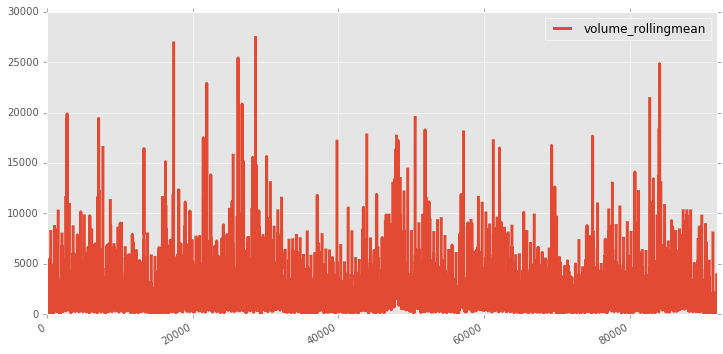

In [19]:
# indicators visualisation
AnalysisClassDay_.TradeDataClass.data.plot(use_index=False, y=['volume_rollingmean'], figsize=(12, 6), linewidth=3)

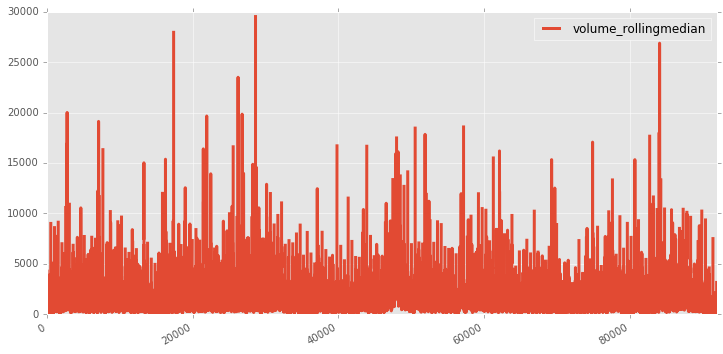

In [20]:
AnalysisClassDay_.TradeDataClass.data.plot(use_index=False, y=['volume_rollingmedian'], figsize=(12, 6), linewidth=3)

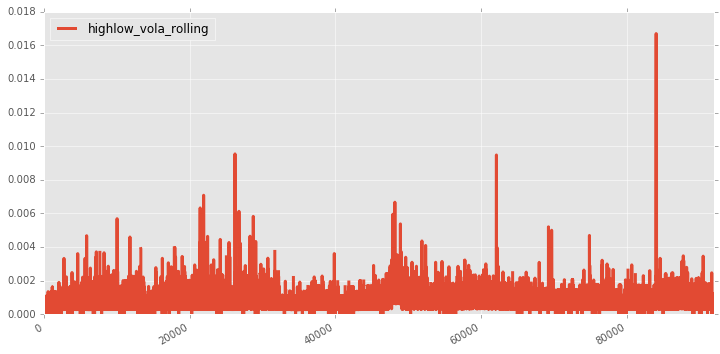

In [21]:
# indicators visualisation
AnalysisClassDay_.TradeDataClass.data.plot(use_index=False, y=['highlow_vola_rolling'], figsize=(12, 6), linewidth=3)

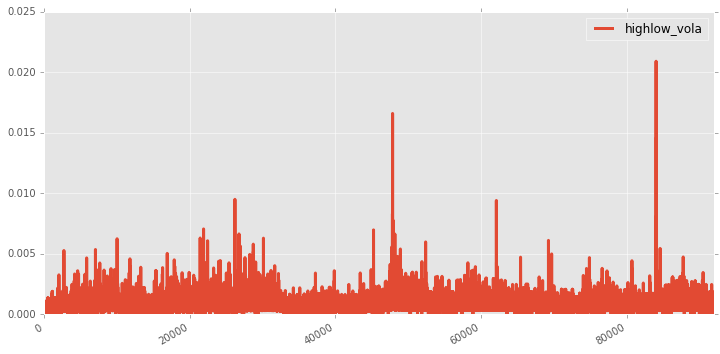

In [22]:
# indicators visualisation
AnalysisClassDay_.TradeDataClass.data.plot(use_index=False, y=['highlow_vola'], figsize=(12, 6), linewidth=3)

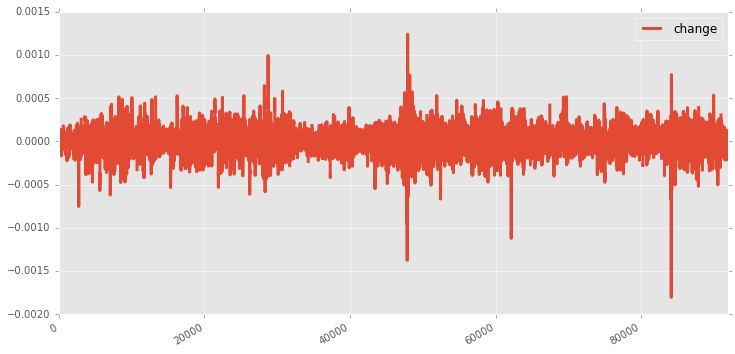

In [23]:
# indicators visualisation
AnalysisClassDay_.TradeDataClass.data.plot(use_index=False, y=['change'], figsize=(12, 6), linewidth=3)

In [19]:

AnalysisClassDay_.generate_npdists_interday()

Creating distributions of indicators based on 300 second bins, each                         distribution will contain data from the last 180 days
Distributions of the following indictors will be created ['volume_rollingmean', 'highlow_vola_rolling', 'change', 'volume_rollingmedian', 'highlow_vola']
Trade data mismatch with previous day detected on day 20-7-2015 loop 68: Len bin_i:                                   511 Len day data: 458
Trade data mismatch with previous day detected on day 21-7-2015 loop 69: Len bin_i:                                   458 Len day data: 511
Trade data mismatch with previous day detected on day 23-7-2015 loop 71: Len bin_i:                                   511 Len day data: 510
Trade data mismatch with previous day detected on day 24-7-2015 loop 72: Len bin_i:                                   510 Len day data: 510
Trade data mismatch with previous day detected on day 27-7-2015 loop 73: Len bin_i:                                   510 Len day data: 511


In [20]:
#AnalysisClassDay_.dict_of_indicator_df

In [21]:
#print('Following indicators found in dict: ' + str(AnalysisClassDay_.dict_of_indicator_df.keys()))

In [22]:

total_bars_per_bin_all_days = AnalysisClassDay_.num_stored_days * AnalysisClassDay_.num_freq_to_include_per_bin

In [23]:
#nparray_indi = np.array(AnalysisClassDay_.TradeDataClass.data[indicator_key])

In [24]:

empty_tuple = ()
cluster_cols = []

for indicator_key in AnalysisClassDay_.dict_of_indicator_df.keys():
 
    df_indi = AnalysisClassDay_.TradeDataClass.data[indicator_key]
    nparray_indi = np.array(df_indi)
    empty_tuple = empty_tuple + (nparray_indi,)
    cluster_cols.append(indicator_key)
    
XX = np.array(empty_tuple).T
contains_nan = np.isnan(XX).any(axis=1)
XX = XX[~contains_nan]    

In [25]:

clusterizor = KMeans(n_clusters=4, random_state=0).fit(XX)
dfclusters = pd.DataFrame(clusterizor.cluster_centers_)
dfclusters.columns = cluster_cols
dfclusters['number'] = np.nan

In [26]:
dfclusters

,volume_rollingmean,highlow_vola_rolling,volume_rollingmedian,change,highlow_vola,number
0,833.009461,0.000611,758.822306,0.000001,0.000599,NaN
1,4380.852093,0.001216,4089.968685,-0.000025,0.001323,NaN
2,2113.557220,0.000885,1960.604843,0.000001,0.000916,NaN
3,10512.606212,0.001917,9976.944785,-0.000108,0.002300,NaN


In [27]:

for index_cluster in dfclusters.index:
    num_occurences = list(clusterizor.labels_).count(index_cluster)
    dfclusters['number'].iloc[index_cluster] = num_occurences

In [28]:
dfclusters

,volume_rollingmean,highlow_vola_rolling,volume_rollingmedian,change,highlow_vola,number
0,833.009461,0.000611,758.822306,0.000001,0.000599,54426.0
1,4380.852093,0.001216,4089.968685,-0.000025,0.001323,6685.0
2,2113.557220,0.000885,1960.604843,0.000001,0.000916,26560.0
3,10512.606212,0.001917,9976.944785,-0.000108,0.002300,652.0


In [29]:

dfclusters.to_csv('clusters_kmeans.csv')

np.bincount(clusterizor.labels_)
list(clusterizor.labels_).count(3)

cluster_centers = dfclusters

#data = np.array(AnalysisClassDay_.dict_of_indicator_df['highlow_vola'][103])
#str(type(data))

#np.array(AnalysisClassDay_.xxxx['Time'])

xx = compute_all_indicators(AnalysisClassDay_.TradeDataClass.data)

tradingdata_day_t = TradeDataClass.subset_day('1-3-2016')

# -----   Build indicators -----

tradingdata_day_t = compute_all_indicators(tradingdata_day_t)

# ------ Build non-parametric distributions ------

# Analysis

# recent_dates = check_within_past_n_days(date_today, TradeDataClass.dates_in_data, num_days = 180)
#tradingdata_day_t.columns

#dist_plot(tradingdata_day_t['volume_rollingmedian'], cut = 0, adj = 1)
#dist_plot(tradingdata_day_t['highlow_vola'], cut = 0, adj = 3)
#dist_plot(tradingdata_day_t['change'], cut = 0, adj = 1)
#dist_plot(tradingdata_day_t['highlow_vola_rolling'], cut = 0, adj = 3)

#tradingdata_day_t['highlow_vola_rolling']
#tradingdata_day_t['change']
#tradingdata_day_t['highlow_vola']
#tradingdata_day_t['volume_rollingmedian']

# ------ Volume weighter

prop_volum = tradingdata_day_t.TotalVolume / sum(tradingdata_day_t.TotalVolume)

np.mean(prop_volum)
# ---- Implementing per day:

#tradingdata_day_t['highlow_vola_rolling']

0.001956947162426614

In [7]:
#
# Additional source code
#

In [8]:
from matplotlib import colors

In [9]:
def DTPandasFrameNormalization(DT_pd):
    """ Data Frame data standardization 
        :param DT_pd: data 
        :return: Data Frame with normalized data
    """    
    DT_pd_features = DT_pd

    mean = DT_pd_features.mean(axis=0)
    std = DT_pd_features.std(axis=0)
    DT_pd_features = (DT_pd_features - mean)/std

    return DT_pd_features

In [10]:
def DTPandasFrameNormalization(DT_pd, columns_list = []):
    """ Data Frame data normalization 
        :param DT_pd: panda's data frame with data 
        :param columns_list: list of column to be normalized 
        :return: Data Frame with normalized data
    """    
    if not columns_list:
        columns_list = DT_pd.columns.tolist()
        
    DT_pd_features = DT_pd[columns_list]

    mean = DT_pd_features.mean(axis=0)
    std = DT_pd_features.std(axis=0)
    DT_pd_features = (DT_pd_features - mean)/std

    return DT_pd_features

In [11]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def PlotElbowCriterion(df, kmean_col, n_cluster):
    """ Elbow criterion plotting 
        :param df: pandas dataframe 
        :param kmean_col: list of the df's columns title related to the indicators 
        :param n_cluster: upper bound for the number of kMeans clusters
        :return: 
    """       
    if(n_cluster < 3):
        raise Exception('The upper bound for clusters should be greater than 2')
        
    cluster_range = range(1, n_cluster+1)

    df_kmean = df.loc[:, kmean_col]
    df_kmean.dropna(axis=0, inplace=True)
    df_kmean = DTPandasFrameNormalization(df_kmean)
    X_train = df_kmean.iloc[:,0:5].as_matrix()
    
    KMs_l = [KMeans(n_clusters = i).fit(X_train) for i in cluster_range]
    centroids = [k.cluster_centers_ for k in KMs_l]

    D_k = [cdist(X_train, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(ds)/X_train.shape[0] for ds in dist]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_range, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')

In [28]:
def ResultsOnIntraDayClusters(df, kmean_col, n_cluster, date_t, plot_flag = True):
    """ Plot intraday results related to the clusters computed from the indicators data 
        :param df: pandas dataframe 
        :param kmean_col: list of the df's columns title related to the indicators 
        :param n_cluster: number of clusters for kMeans approach
        :param date_t: day to be plotted
        :param plot_flag: False to avoid plotting, True - otherwise 
        :return df_clusters, df_kmean: df_clusters - dataframe with kMeans computation results 
                                       df_kmean - processed df dataframe    
    """      
    if(n_cluster < 2):
        raise Exception('The number of cluster should be greater than 1')
    
    df_kmean = df.loc[:, kmean_col]
    
    print len(df_kmean)
    
    df_kmean.dropna(axis=0, inplace=True)
    df_kmean = DTPandasFrameNormalization(df_kmean)
    
    print len(df_kmean)
    day_list_t = np.unique(df.index.date)
    
    itemindex = np.where(day_list_t == pd.to_datetime(date_t).date())
    if itemindex[0].size == 0:
        raise Exception('There is no data for the given date: ' + date_t)
    
    print('KMean approach has started...')
    kmean_model = KMeans(n_clusters=n_cluster, random_state=0)
    kmean_model_fit = kmean_model.fit(df_kmean)
    print('KMean approach has finished...')
    
    df_kmean['class'] = np.array(kmean_model_fit.labels_) 
    
    df_clusters = pd.DataFrame(kmean_model_fit.cluster_centers_)
    df_clusters.columns = kmean_col
    df_clusters['number'] = np.nan
    
    for index_cluster in df_clusters.index:
        num_occurences = list(kmean_model_fit.labels_).count(index_cluster)
        df_clusters['number'].iloc[index_cluster] = num_occurences
    
    if not plot_flag:
        return df_clusters, df_kmean
   
    plt.rc('font', weight='bold')
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    plt.rc('figure', titlesize=14)  
    plt.rc('axes', titlesize=14)
    plt.rc('axes', labelsize=14) 
    
    actual_day = day_list_t[itemindex]
    cols = colors.cnames.keys()
    color_list = [cols[i] for i in df_kmean[df_kmean.index.date == actual_day]['class']]    

    print len(df_kmean)
    print len(df)
    
    x = df_kmean[df_kmean.index.date == actual_day].index.time
    y = df[df.index.date == actual_day]['Close']
    
    print x.size
    print y.size
 
    fig, ax = plt.subplots(figsize=(24, 10), linewidth=3)    
    fig.suptitle('Clusters - DAY: ' + str(actual_day[0]))
    ax.set(ylabel='Close')
    ax.set(xlabel='Time')

    ax.plot(x, y, linestyle="-", linewidth=1, color='yellow')
    f_sc = ax.scatter(x, y, c=color_list, s=40)
    
    f_sc_l = tuple([f_sc]*n_cluster)
    cl_n_l = tuple(['Cluster ' + str(i) for i in range(0, n_cluster)])
    leg = ax.legend(f_sc_l, cl_n_l, scatterpoints=1, loc='lower left', ncol=2, fontsize=14)

    for i in range(0, n_cluster):
        leg.legendHandles[i].set_color(cols[i])
    
    return df_clusters, df_kmean

In [29]:
# read data from the AnalysisClassDay object
df_ex_min = AnalysisClassDay_.TradeDataClass.data

In [36]:
#df_ex_min.to_csv("/Users/yesterdays/Downloads/IPythonData/df_ex_min.csv")

In [353]:
len(df_ex_min)

91903

In [31]:
df_ex_min.dropna(axis=0, inplace=True)

In [32]:
df_ex_min.index

DatetimeIndex(['2015-10-04 03:21:00', '2015-10-04 03:22:00',
               '2015-10-04 03:23:00', '2015-10-04 03:24:00',
               '2015-10-04 03:25:00', '2015-10-04 03:26:00',
               '2015-10-04 03:27:00', '2015-10-04 03:28:00',
               '2015-10-04 03:29:00', '2015-10-04 03:30:00',
               ...
               '2015-12-28 11:22:00', '2015-12-28 11:23:00',
               '2015-12-28 11:24:00', '2015-12-28 11:25:00',
               '2015-12-28 11:26:00', '2015-12-28 11:27:00',
               '2015-12-28 11:28:00', '2015-12-28 11:29:00',
               '2015-12-28 11:30:00', '2015-12-28 11:31:00'],
              dtype='datetime64[ns]', length=88323, freq=None)

In [33]:
# #################################################################################################################
#                       Here a source code for the LSTM part of the project is started                            #
# #################################################################################################################

In [12]:
def isNaN(num):
    return num != num

In [13]:
def ret_next_entry_point(df, actual_point):
    """ Return next entry point to continue labelling process 
        :param df: pandas dataframe 
        :param actual_point: actual backward procedure position (index) in the df 
        :param n_cluster: upper bound for the number of kMeans clusters
        :return: i - index of the next entry point; if entry point is not found, then np.nan
                 True, if entry point is found; False - otherwise 
    """     
    df_len = len(df)
    from_index = abs(actual_point)
    
    for i in range(from_index, df_len+1):
        
        if isNaN(df.iloc[-i]['Label']):
            return i, True
    
    return np.nan, False

In [14]:
def ret_labels(df, entry_point, profit_threshold, backward_depth, global_sol=False):
    """ Return next entry point to continue labelling process 
        :param df: pandas dataframe 
        :param entry_point: df index - start point for the backward labelling procedure  
        :param profit_threshold: profit low bound for the backward labelling procedure
        :param backward_depth: backward window size (backward steps number)
        :param global_sol: if True - provide labelling based on the "max profit" criterion, 
                           otherwise, - provide labelling based on the "closeness" criterion  
        :return: labels: dictionary of labels, where key is - df index, and value is an assigned label
    """     
    labels = {}
    df_len = len(df)
    labels[entry_point] = 0
    
    entry_point_close = df.iloc[-entry_point]['Close']
    
    if global_sol:
        
        buy_point = 0
        prev_close_diff = 0
        
        for i in range(1, backward_depth+1):  
            
            if (entry_point+i) > df_len:
                break
            
            close_diff = (entry_point_close - df.iloc[-(entry_point+i)]['Close'])
            
            if (close_diff >= profit_threshold) and (close_diff > prev_close_diff):
                prev_close_diff = close_diff
                buy_point = entry_point+i
                
        if prev_close_diff > 0:
            labels[entry_point] = -1
            labels[buy_point] = 1
    else:
        
        for i in range(1, backward_depth+1):
    
            if (entry_point+1) > df_len:
                break
              
            close_diff = (entry_point_close - df.iloc[-(entry_point+i)]['Close'])
            
            if close_diff >= profit_threshold:
                labels[entry_point] = -1
                labels[(entry_point+i)] = 1
                break
     
    return labels

In [15]:
def GetLabeledDF(df, profit_threshold, backward_depth, global_sol=False):
    """ Provide labeled dataframe with columns: Timestamp (as df index), Close, Label
        :param df: pandas dataframe 
        :param profit_threshold: profit low bound for the backward labelling procedure
        :param backward_depth: backward window size (backward steps number)
        :param global_sol: if True - provide labelling based on the "max profit" criterion, 
                           otherwise, - provide labelling based on the "closeness" criterion  
        :return: labels: dictionary of labels, where key is - df index, and value is an assigned label
    """      
    df_labeled = df[['Close']].copy()
    df_labeled['Label'] = np.nan 
    
    day_list_t = np.unique(df.index.date)
    labels = {}
    
    for actual_day in day_list_t:
      
        df_day_data = df_labeled[df_labeled.index.date == actual_day]

        actual_point = -1
        entry_point_res = True
   
        while entry_point_res:
        
            actual_point, entry_point_res = ret_next_entry_point(df_day_data, actual_point)
            
            if not entry_point_res:      
                break
            
            labels.clear()  
            labels = ret_labels(df_day_data, actual_point, profit_threshold, backward_depth, True)
        
            for key, value in labels.iteritems():
                df_day_data.set_value(df_day_data.index[-key],'Label', value)
             
        #df_ex.loc[df_ex.index.date == actual_date]['Label'] = df_day_data['Label']
        df_labeled.ix[df_labeled.index.date == actual_day, 'Label'] = df_day_data['Label']

    return df_labeled

In [8]:
df_ex_min = pd.read_csv("/Users/yesterdays/Downloads/IPythonData/df_ex_min.csv", index_col=0)
df_ex_min.index = pd.to_datetime(df_ex_min.index)

In [39]:
profit_threshold = 3
backward_depth = 5

df_ex = GetLabeledDF(df_ex_min, profit_threshold, backward_depth, global_sol=False)

In [41]:
df_ex.iloc[-91902]

Close    3697.0
Label       0.0
Name: 2015-10-04 03:22:00, dtype: float64

In [13]:
# # # 
# Just for the visualisation the obtained results (will be not included into the final version)
# # # 

In [169]:
df_ex.to_csv(".../labeled_dataset.csv")

In [36]:
df_ex = pd.read_csv(".../labeled_dataset.csv", index_col=0)
df_ex.index = pd.to_datetime(df_ex.index)

In [37]:
df_ex.head()

,Close,Label,CloseNorm,FDiff
2015-10-04 03:21:00,3698.0,0.0,1.598093,NaN
2015-10-04 03:22:00,3697.0,0.0,1.592433,-1.0
2015-10-04 03:23:00,3698.0,0.0,1.598093,1.0
2015-10-04 03:24:00,3697.0,0.0,1.592433,-1.0
2015-10-04 03:25:00,3698.0,0.0,1.598093,1.0


In [7]:
day_list_t = np.unique(df_ex.index.date)

In [8]:
actual_date = day_list_t[len(day_list_t)-3]
df_day_data = df_ex[df_ex.index.date == actual_date]

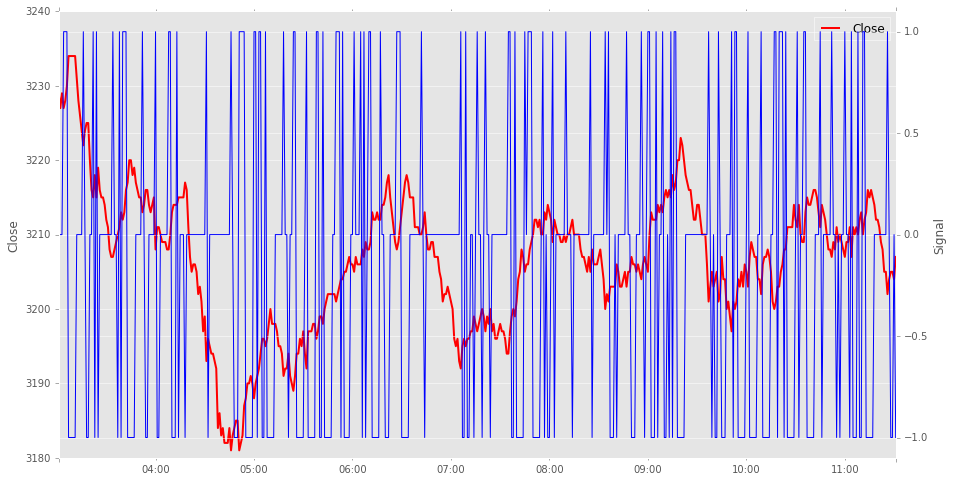

In [9]:
#
# This visualisation will be changed (the buy and sell positions will be market by points of different color)
#
fig = plt.figure(figsize=(15, 8)) 
ax = fig.add_subplot(111) 
ax2 = ax.twinx() 

ax2.set_autoscaley_on(False)
ax2.set_ylim([-1.1,1.1])

df_day_data.plot(ax=ax, 
                 y=['Close'], 
                 color='red',  
                 linewidth=2) 
                 #kind='bar') 
                 #legend=False)

df_day_data.plot(ax=ax2, 
                 y=['Label'], 
                 color='blue', 
                 linewidth=1, 
                 #kind='bar', 
                 legend=False)

ax.set_ylabel('Close')
ax2.set_ylabel('Signal')

In [13]:
def labels_stat_df(df):
    
    labels = [0,-1,+1]
    l_stat = {}
   
    if 'Label' not in df.columns:
        print("There is no column 'Label' in the dataframe")
        return l_stat
  
    for l in labels: 
        l_stat[l] = len(df[df['Label'] == l])
    
    return l_stat

In [14]:
def labels_stat_np(np_a):
    
    labels = [0,-1,+1]
    l_stat = {}
   
    for l in labels: 
        l_stat[l] = np_a[np_a==l].shape[0]
    
    return l_stat

In [15]:
def get_training_data(df, sample_dim, col_f, col_l):
    
    X_train = []
    Y_train = []
    
    for i in range(1, len(df)-sample_dim):
        X_train.append(df[col_f].iloc[i:i+sample_dim].as_matrix())
        Y_train.append(df[col_l].iloc[i+sample_dim].as_matrix())  
       
    return np.array(X_train), np.array(Y_train)

In [24]:
# Close normalisation
df_ex['CloseNorm'] = DTPandasFrameNormalization(df_ex, ['Close'])
# FDiff computation
df_ex['FDiff'] = df_ex['Close'] - df_ex['Close'].shift(1)

In [16]:
#df_ex.plot(y=['FDiff'], figsize=(15, 8), linewidth=2, use_index=False)

In [27]:
# compute number of samples associated with each labels
number_of_samples = 91903
l_stats = labels_stat_df(df_ex.iloc[1:number_of_samples])
print "Labels count results: {}".format(l_stats)

min_l_key, min_l_value = min(l_stats.iteritems(), key=lambda v:v[1])
print "Label {} with minimum number of samples: {}".format(min_l_key, min_l_value)

Labels count results: {0: 50803, 1: 13781, -1: 27318}
Label 1 with minimum number of samples: 13781


In [28]:
# create training set X
number_of_samples = 30000 # this limitation because of the Python's run-time error I have on my machine; 
                          # looks like a memory related error
backward_depth = 5
X,Y = get_training_data(df_ex.iloc[1:number_of_samples], backward_depth-1, ['FDiff','Label','CloseNorm'], ['Label'])

In [29]:
# training set X labels 
l_stats = labels_stat_np(Y)
print "Labels count results: {}".format(l_stats)

min_l_key, min_l_value = min(l_stats.iteritems(), key=lambda v:v[1])
print "Label {} with minimum number of samples: {}".format(min_l_key, min_l_value)

Labels count results: {0: 15775, 1: 4757, -1: 9462}
Label 1 with minimum number of samples: 4757


In [30]:
print "Shape of the X: {}".format(X.shape)
print "Example of the X sample:"
print X[110]

Shape of the X: (29994, 4, 3)
Example of the X sample:
[[-1.          1.          1.61507103]
 [ 2.          0.          1.62638985]
 [ 1.         -1.          1.63204926]
 [ 2.         -1.          1.64336809]]


In [34]:
# # Due to unbalanced X, provide a random undersampling procedure.
i_minus_1_mask = (Y == -1)
i_zero_mask = (Y == 0)
i_plus_1_mask = (Y == 1)

X_minus_1 = X[i_minus_1_mask.flatten(),:,:]
Y_minus_1 = Y[i_minus_1_mask.flatten()]
              
X_zero = X[i_zero_mask.flatten(),:,:]
Y_zero = Y[i_zero_mask.flatten()]
              
X_plus_1 = X[i_plus_1_mask.flatten(),:,:]
Y_plus_1 = Y[i_plus_1_mask.flatten()]

np.random.seed(424)

i_minus_1_indices = np.random.choice(X_minus_1.shape[0], min_l_value, replace=False)
X_minus_1 = X_minus_1[i_minus_1_indices,:,:]
Y_minus_1 = Y_minus_1[i_minus_1_indices]

i_zero_indices = np.random.choice(X_zero.shape[0], min_l_value, replace=False)
X_zero = X_zero[i_zero_indices,:,:]
Y_zero = Y_zero[i_zero_indices]

i_plus_1_indices = np.random.choice(X_plus_1.shape[0], min_l_value, replace=False) 
X_plus_1 = X_plus_1[i_plus_1_indices,:,:]
Y_plus_1 = Y_plus_1[i_plus_1_indices]

X_pr = np.concatenate((X_minus_1, X_zero, X_plus_1), axis=0)
Y_pr = np.concatenate((Y_minus_1, Y_zero, Y_plus_1), axis=0)

In [11]:
def lstm_random_undersampling(X,Y, r_seed = 424):
    
    i_minus_1_mask = (Y == -1)
    i_zero_mask = (Y == 0)
    i_plus_1_mask = (Y == 1)

    X_minus_1 = X[i_minus_1_mask.flatten(),:,:]
    Y_minus_1 = Y[i_minus_1_mask.flatten()]
              
    X_zero = X[i_zero_mask.flatten(),:,:]
    Y_zero = Y[i_zero_mask.flatten()]
              
    X_plus_1 = X[i_plus_1_mask.flatten(),:,:]
    Y_plus_1 = Y[i_plus_1_mask.flatten()]

    np.random.seed(r_seed)
    
    # training set X labels 
    l_stats = labels_stat_np(Y)
    min_l_key, min_l_value = min(l_stats.iteritems(), key=lambda v:v[1])

    i_minus_1_indices = np.random.choice(X_minus_1.shape[0], min_l_value, replace=False)
    X_minus_1 = X_minus_1[i_minus_1_indices,:,:]
    Y_minus_1 = Y_minus_1[i_minus_1_indices]

    i_zero_indices = np.random.choice(X_zero.shape[0], min_l_value, replace=False)
    X_zero = X_zero[i_zero_indices,:,:]
    Y_zero = Y_zero[i_zero_indices]

    i_plus_1_indices = np.random.choice(X_plus_1.shape[0], min_l_value, replace=False) 
    X_plus_1 = X_plus_1[i_plus_1_indices,:,:]
    Y_plus_1 = Y_plus_1[i_plus_1_indices]

    X_pr = np.concatenate((X_minus_1, X_zero, X_plus_1), axis=0)
    Y_pr = np.concatenate((Y_minus_1, Y_zero, Y_plus_1), axis=0)
    
    return X_pr, Y_pr

In [9]:
import cPickle

In [32]:
#X_pr,Y_pr = lstm_random_undersampling(X,Y,424)

In [301]:
#cPickle.dump(X, open("/Users/yesterdays/Downloads/IPythonData/X_lstm.pkl", "wb" ))
#cPickle.dump(Y, open("/Users/yesterdays/Downloads/IPythonData/Y_lstm.pkl", "wb" ))

In [17]:
Xp = cPickle.load(open( ".../X_lstm.pkl", "rb" ))
Yp = cPickle.load(open( ".../Y_lstm.pkl", "rb" ))
X_pr,Y_pr = lstm_random_undersampling(Xp,Yp,424)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pr, Y_pr, test_size=0.2, random_state=42)

In [38]:
X_train.shape

(11416, 4, 3)

In [21]:
print Y_train[Y_train==-1].shape
print Y_train[Y_train==0].shape
print Y_train[Y_train==1].shape

(3784,)
(3828,)
(3804,)


In [22]:
print Y_test[Y_test==-1].shape
print Y_test[Y_test==0].shape
print Y_test[Y_test==1].shape

(973,)
(929,)
(953,)


In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from keras.regularizers import l1, l2

Using Theano backend.


In [24]:
encoder = LabelEncoder()
encoder.fit(Y_train.flatten())
encoded_Y_train = encoder.transform(Y_train.flatten())
dummy_Y_train = np_utils.to_categorical(encoded_Y_train)

In [25]:
encoder = LabelEncoder()
encoder.fit(Y_test.flatten())
encoded_Y_test = encoder.transform(Y_test.flatten())
dummy_Y_test = np_utils.to_categorical(encoded_Y_test)

In [242]:
#dummy_Y_test[0:20]

In [243]:
#Y_test[0:20]

In [45]:
batch_size = 180
features_number = 3
model = Sequential()

model.add(LSTM(250, 
               batch_input_shape=(batch_size, 
                                  backward_depth-1, 
                                  features_number),
               dropout_W=0.2,
               dropout_U=0.2,
               stateful=False,
               return_sequences=False))
model.add(Dropout(0.2))
#model.add(LSTM(100, activation='sigmoid'))
#model.add(Dropout(0.5))
#model.add(Dense(1, activation='relu'))
model.add(Dense(3, init='normal', activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 
#print(model.summary())

In [26]:
#model.fit(X_train, dummy_Y_train, nb_epoch=100, shuffle=True, verbose=1)
model_pkl = cPickle.load(open( "/Users/yesterdays/Downloads/IPythonData/lstm_v1.pkl", "rb" ))

In [274]:
scores = model_pkl.evaluate(X_test, dummy_Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

2848/2855 [============================>.] - ETA: 0sAccuracy: 57.16%


In [34]:
#model.summary()

In [307]:

import sys
sys.setrecursionlimit(10000)
cPickle.dump(model, open("/Users/yesterdays/Downloads/IPythonData/lstm_v1.pkl", "wb" ))

In [41]:
model_pkl = cPickle.load(open( "/Users/yesterdays/Downloads/IPythonData/lstm_v1.pkl", "rb" ))

In [31]:
def _f_(df_actual_day, t_info_0, t_info_1, long_flag=True):
    """ Provide close time and price for long/short position
           :param df_actual_day: actual day market data
           :param t_info_0: time related to the open positon
           :param t_info_1: Close price related to the t_info_0
           :param long_flag: long_flag == True if backtesting for long position, otherwise - for short one.
           :return: time to close the position and related Close value
    """
    if long_flag:
        df = df_actual_day[(df_actual_day.index > pd.to_datetime(t_info_0)) & (df_actual_day['Close'] > t_info_1)]
    else:
        df = df_actual_day[(df_actual_day.index > pd.to_datetime(t_info_0)) & (df_actual_day['Close'] < t_info_1)]

    if len(df) == 0:
        close_time = df_actual_day.index[len(df_actual_day) - 1]
        close_price = df_actual_day['Close'][len(df_actual_day) - 1]
    else:
        close_time = df.index[0]
        close_price = df['Close'][0]

    return close_time, close_price

In [32]:
def get_training_sample(df, sample_dim, col_f):
    """ Training samples generator
           :param df: labelling related pandas dataframe
           :param col_f: df's columns related to the training data
           :return: dictionary with computed numbers key - label, value - quantity
      """

    for i in range(1, len(df)-sample_dim):
        yield [df.index[i+sample_dim], df['Close'].iloc[i+sample_dim]], \
            np.array(df[col_f].iloc[i:i+sample_dim].as_matrix()).reshape((1,sample_dim,len(col_f)))

In [33]:
def lstm_bt(df, model, trading_type, backward_depth, col_df, order_prb_threshold=0.95):
    """ Backtesting
           :param df: dataframe with data that was not used in the LSTM training
           :param model: trained LSTM model
           :param trading_type: True - long, False - short.
           :param backward_depth: backward depth value used for labelling procedure
           :param col_df: list of the columns title
           :param order_prb_threshold: Close price related to the t_info_0
           :return: pandas dataframe with backtesting results
    """

    df_PnL = pd.DataFrame(columns=['Open_Time', 'Open_Price', 'Close_Time', 'Close_Price'])

    class_ = 0
    if trading_type:
        class_ = 2

    day_list_t = np.unique(df.index.date)

    for actual_day in day_list_t:

        df_actual_day = df[df.index.date == actual_day]

        samples_g = get_training_sample(df_actual_day, backward_depth - 1, col_df)

        for t_info, sample in samples_g:

            pr_class = model.predict_classes(sample, verbose=0)
            pr_prob = model.predict_proba(sample, verbose=0)[0][pr_class][0]

            if (pr_class == class_) & (pr_prob > order_prb_threshold):
                close_time, close_price = _f_(df_actual_day, t_info[0], t_info[1], trading_type)

                df_PnL.loc[len(df_PnL)] = [t_info[0],
                                           t_info[1],
                                           close_time,
                                           close_price]

    df_PnL.index = pd.to_datetime(df_PnL['Open_Time'])
    df_PnL['PnL'] = df_PnL['Close_Price'] - df_PnL['Open_Price']


    return df_PnL

In [260]:
def _f_f(df_actual_day, t_info_0, f_t, long_flag=True):
    """ Provide close time and price for long/short position
           :param df_actual_day: actual day market data
           :param t_info_0: time related to the open positon
           :param f_t: 
           :param long_flag: long_flag == True if backtesting for long position, otherwise - for short one.
           :return: time to close the position and related Close value
    """
    df = df_actual_day[(df_actual_day.index >= pd.to_datetime(t_info_0))]

    if len(df) > f_t:
        close_time = df.index[f_t-1]
        close_price = df['Close'][f_t-1]
    else:
        close_time = df.index[len(df)-1]
        close_price = df['Close'][len(df)-1]   

    return close_time, close_price

In [399]:
# backtesting for the fixed trading legnth
def lstm_bt_f(df, model, trading_type, backward_depth, col_df, order_prb_threshold=0.95):
    """ Backtesting
           :param df: dataframe with data that was not used in the LSTM training
           :param model: trained LSTM model
           :param trading_type: True - long, False - short.
           :param backward_depth: backward depth value used for labelling procedure
           :param col_df: list of the columns title
           :param order_prb_threshold: Close price related to the t_info_0
           :return: pandas dataframe with backtesting results
    """

    f_t = 10
    
    df_PnL = pd.DataFrame(columns=['Open_Time', 'Open_Price', 'Close_Time', 'Close_Price'])

    class_ = 0
    if not trading_type:
        class_ = 2

    day_list_t = np.unique(df.index.date)

    for actual_day in day_list_t:

        df_actual_day = df[df.index.date == actual_day]

        samples_g = get_training_sample(df_actual_day, backward_depth - 1, col_df)

        for t_info, sample in samples_g:

            pr_class = model.predict_classes(sample, verbose=0)
            pr_prob = model.predict_proba(sample, verbose=0)[0][pr_class][0]

            if (pr_class == class_) & (pr_prob > order_prb_threshold):
                close_time, close_price = _f_f(df_actual_day, t_info[0], f_t, trading_type)

                df_PnL.loc[len(df_PnL)] = [t_info[0],
                                           t_info[1],
                                           close_time,
                                           close_price]

    df_PnL.index = pd.to_datetime(df_PnL['Open_Time'])    
    df_PnL['PnL'] = df_PnL['Close_Price'] - df_PnL['Open_Price']

    return df_PnL

In [34]:
def bt_plot(df):
    """ Plot backtesting results
           :param df: dataframe with data
           :return:
    """
    df_PnL_d_prf = pd.DataFrame(columns=['PnL'])
    df_PnL_d_prf['PnL'] = df['PnL'].groupby([df.index.year,
                                             df.index.month,
                                             df.index.day]).sum()

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
    axes.set_ylabel("Open/Close prices difference")
    axes.set_xlabel("Date")

    df_PnL_d_prf.plot(ax=axes, y='PnL', title="PnL per day",
                      kind='bar',
                      figsize=(25, 10))

In [39]:
df_ex.head()

,Close,Label,CloseNorm,FDiff
2015-10-04 03:21:00,3698.0,0.0,1.598093,NaN
2015-10-04 03:22:00,3697.0,0.0,1.592433,-1.0
2015-10-04 03:23:00,3698.0,0.0,1.598093,1.0
2015-10-04 03:24:00,3697.0,0.0,1.592433,-1.0
2015-10-04 03:25:00,3698.0,0.0,1.598093,1.0


In [ ]:
backward_depth = 5
number_of_samples = 30000
col_df = ['FDiff', 'Label', 'CloseNorm']
df_PnL_sl = lstm_bt_f(df_ex[number_of_samples::], model_pkl, True, backward_depth, col_df)

In [401]:
df_PnL_l.head()

,Open_Time,Open_Price,Close_Time,Close_Price,PnL
Open_Time,,,,,
2015-01-09 03:22:00,2015-01-09 03:22:00,3187.0,2015-01-09 03:31:00,3175.0,-12.0
2015-01-09 03:24:00,2015-01-09 03:24:00,3182.0,2015-01-09 03:33:00,3182.0,0.0
2015-01-09 03:30:00,2015-01-09 03:30:00,3179.0,2015-01-09 03:39:00,3181.0,2.0
2015-01-09 04:15:00,2015-01-09 04:15:00,3167.0,2015-01-09 04:24:00,3161.0,-6.0
2015-01-09 04:25:00,2015-01-09 04:25:00,3159.0,2015-01-09 04:34:00,3158.0,-1.0


In [389]:
#df_PnL_s['PnL'] = df_PnL_s['PnL']*-1
df_PnL_s.head()

,Open_Time,Open_Price,Close_Time,Close_Price,PnL
Open_Time,,,,,
2015-01-09 03:06:00,2015-01-09 03:06:00,3202.0,2015-01-09 03:15:00,3203.0,-1.0
2015-01-09 03:07:00,2015-01-09 03:07:00,3201.0,2015-01-09 03:16:00,3200.0,1.0
2015-01-09 03:08:00,2015-01-09 03:08:00,3207.0,2015-01-09 03:17:00,3195.0,12.0
2015-01-09 03:09:00,2015-01-09 03:09:00,3204.0,2015-01-09 03:18:00,3195.0,9.0
2015-01-09 03:16:00,2015-01-09 03:16:00,3200.0,2015-01-09 03:25:00,3186.0,14.0


In [395]:
df_PnL_sl.head()

,Open_Time,Open_Price,Close_Time,Close_Price,PnL
Open_Time,,,,,
2015-01-09 03:06:00,2015-01-09 03:06:00,3202.0,2015-01-09 03:15:00,3203.0,1.0
2015-01-09 03:07:00,2015-01-09 03:07:00,3201.0,2015-01-09 03:16:00,3200.0,-1.0
2015-01-09 03:08:00,2015-01-09 03:08:00,3207.0,2015-01-09 03:17:00,3195.0,-12.0
2015-01-09 03:09:00,2015-01-09 03:09:00,3204.0,2015-01-09 03:18:00,3195.0,-9.0
2015-01-09 03:16:00,2015-01-09 03:16:00,3200.0,2015-01-09 03:25:00,3186.0,-14.0


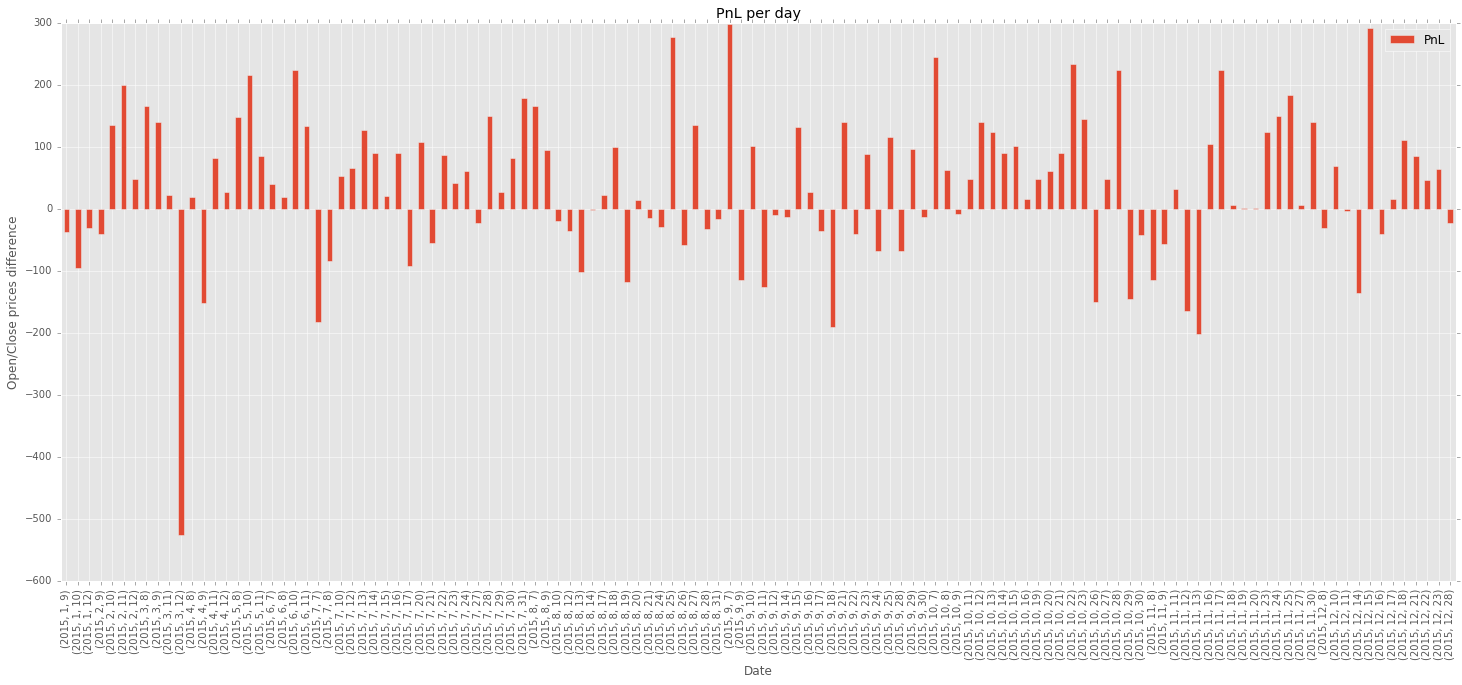

In [396]:
bt_plot(df_PnL_sl)

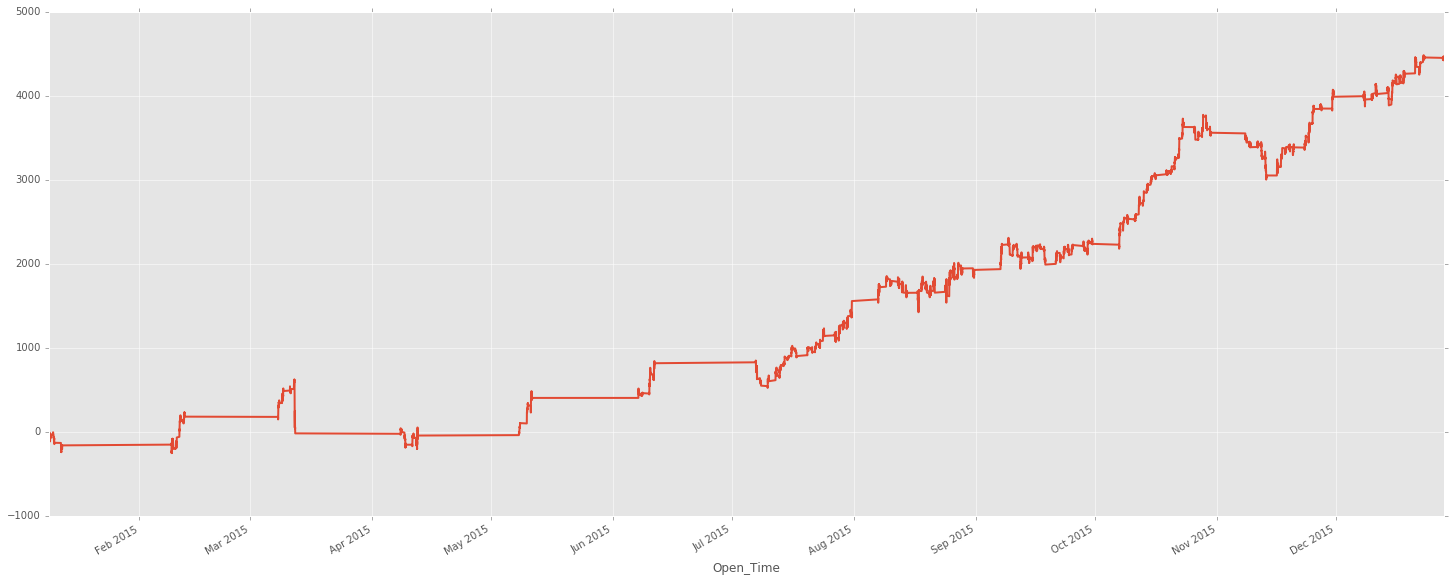

In [397]:
cumsum = df_PnL_sl['PnL'].cumsum()
cumsum.plot(figsize=(25, 10), linewidth=2)

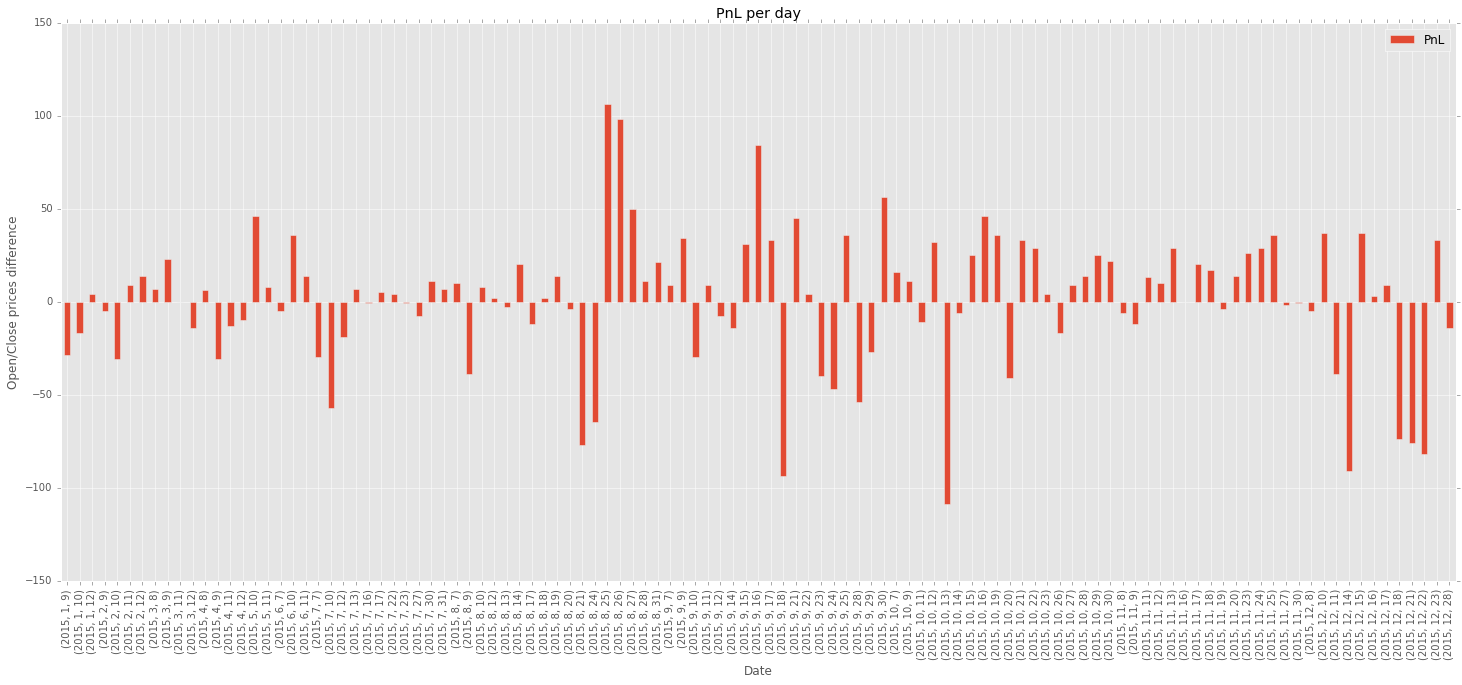

In [314]:
bt_plot(df_PnL_l)

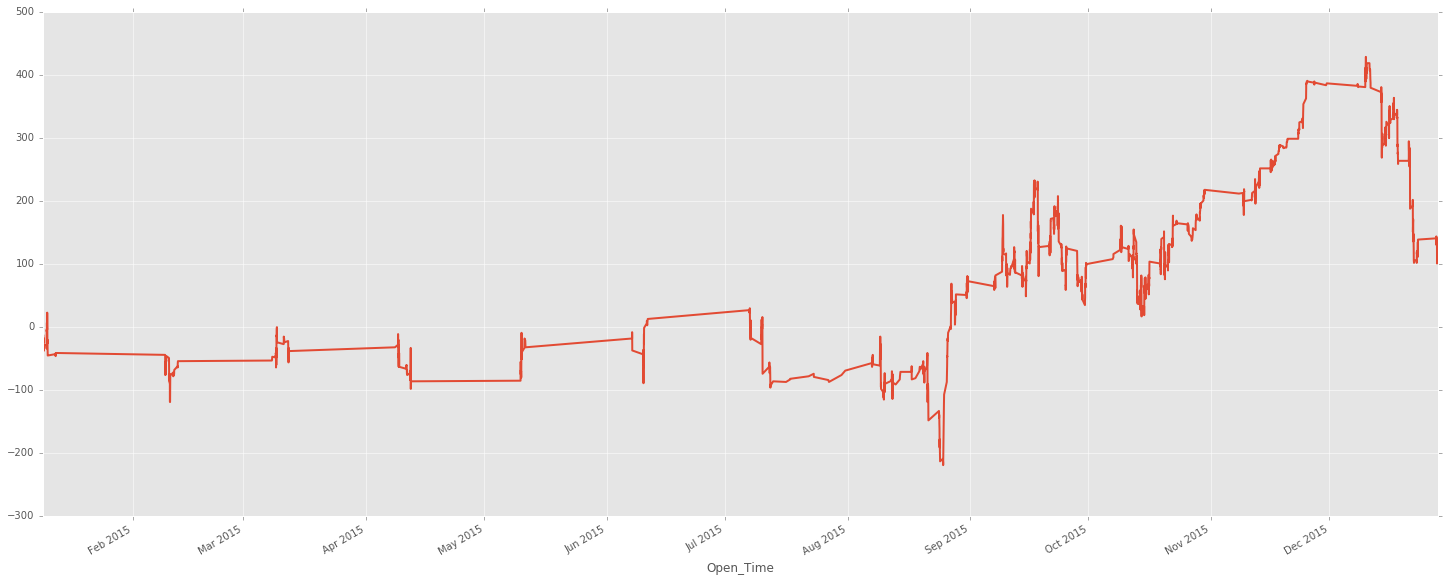

In [398]:
cumsum = df_PnL_l['PnL'].cumsum()
cumsum.plot(figsize=(25, 10), linewidth=2)

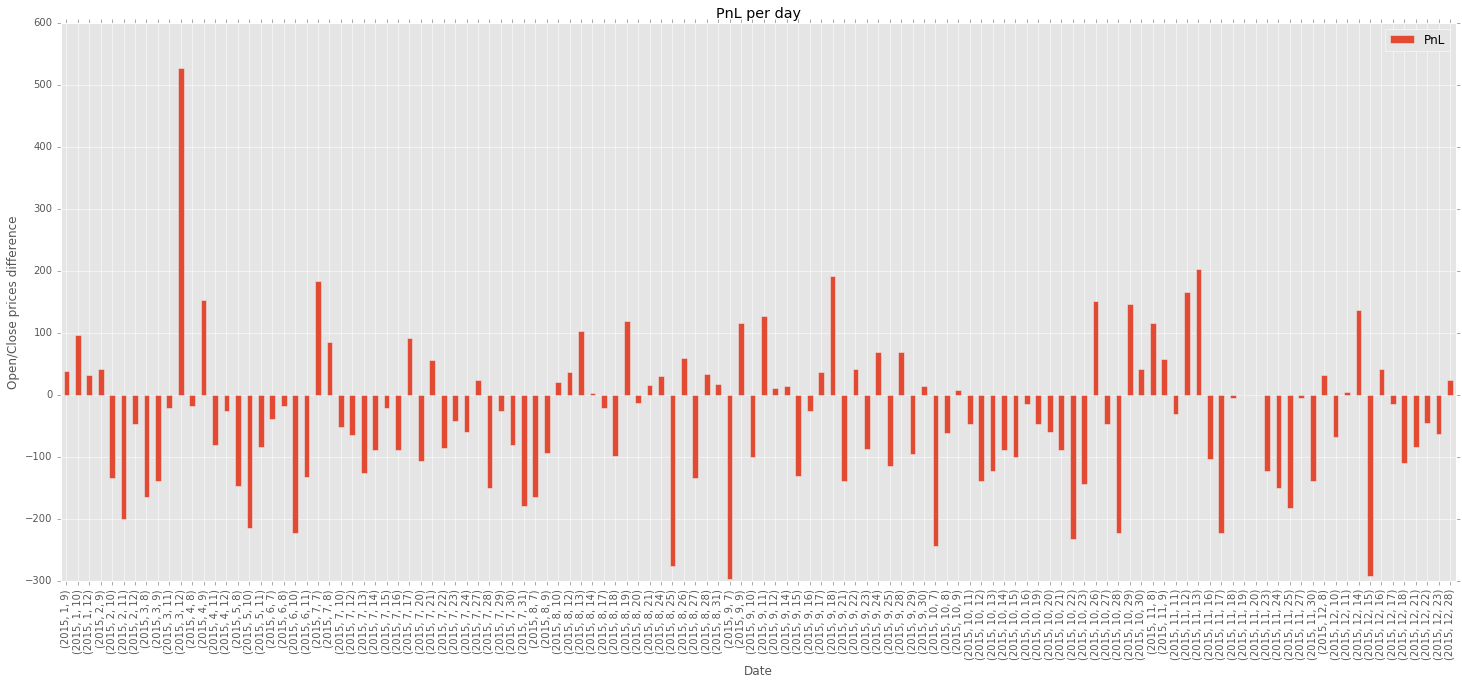

In [384]:
bt_plot(df_PnL_s)

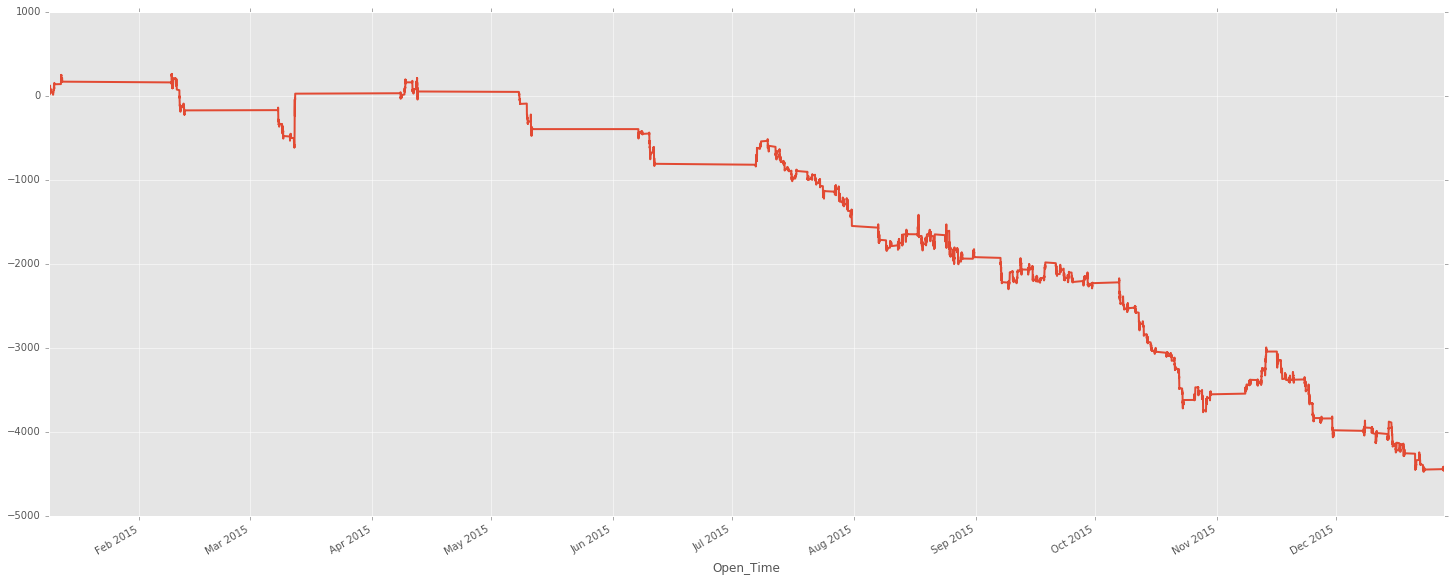

In [386]:
cumsum = df_e_ratio_s['PnL'].cumsum()
cumsum.plot(figsize=(25, 10), linewidth=2)

In [388]:
df_e_ratio_s = e_ratio_f_(df_PnL_s.copy(), df_ex_min, False)

In [390]:
df_e_ratio_s.head()

,Open_Time,Open_Price,Close_Time,Close_Price,PnL,Trading_Duration,ATR,MAE_1,MAE_2,MAE_3,...,MAE_9,MFE_1,MFE_2,MFE_3,MFE_4,MFE_5,MFE_6,MFE_7,MFE_8,MFE_9
Open_Time,,,,,,,,,,,,,,,,,,,,,
2015-01-09 03:06:00,2015-01-09 03:06:00,3202.0,2015-01-09 03:15:00,3203.0,-1.0,10.0,9.000000,2.0,5.0,4.0,...,2.0,2.0,2.0,0.0,2.0,6.0,7.0,8.0,6.0,6.0
2015-01-09 03:07:00,2015-01-09 03:07:00,3201.0,2015-01-09 03:16:00,3200.0,1.0,10.0,8.928571,6.0,5.0,5.0,...,3.0,1.0,0.0,1.0,5.0,6.0,7.0,5.0,5.0,3.0
2015-01-09 03:08:00,2015-01-09 03:08:00,3207.0,2015-01-09 03:17:00,3195.0,12.0,10.0,9.142857,0.0,0.0,0.0,...,0.0,5.0,7.0,11.0,12.0,13.0,11.0,11.0,9.0,13.0
2015-01-09 03:09:00,2015-01-09 03:09:00,3204.0,2015-01-09 03:18:00,3195.0,9.0,10.0,8.785714,2.0,0.0,0.0,...,0.0,4.0,8.0,9.0,10.0,8.0,8.0,6.0,10.0,11.0
2015-01-09 03:16:00,2015-01-09 03:16:00,3200.0,2015-01-09 03:25:00,3186.0,14.0,10.0,5.500000,0.0,0.0,0.0,...,0.0,6.0,7.0,9.0,8.0,10.0,15.0,17.0,21.0,19.0


In [391]:
df_e_ratio_s.to_csv("/Users/yesterdays/Downloads/e_ratio_df_s.csv")

In [ ]:
def ATR(df, n=14):
    
    df['Close_Shift_1'] = df['Close'].shift(1) 
    df.set_value(df.index[0],'Close_Shift_1', df['Close'][0])
    
    df_t = pd.DataFrame()
    df_t['HL'] = df.High - df.Low
    df_t['HCp'] = abs(df.High - df.Close_Shift_1)
    df_t['LCp'] = abs(df.Low - df.Close_Shift_1)
    df['TR'] = df_t.apply(max, axis=1)
    
    df['ATR'] = df['TR'].rolling(window=n).mean()
    df['ATR'].fillna(df['ATR'][n-1], inplace=True)

    return df

In [268]:
def e_ratio_f(df_trading_data, df_market_data, n=14):
    
    df_market_data_ex = ATR(df_market_data, n)

    df_trading_data['MAE'] = np.nan
    df_trading_data['MFE'] = np.nan
    df_trading_data['Trading_Duration'] = np.nan
    df_trading_data['ATR'] = np.nan
    
    for value in df_trading_data.index:
        
        close_timestamp = df_trading_data[df_trading_data.index == value]['Close_Time'][0]

        close = df_market_data_ex[(df_market_data_ex.index >= value) & 
                                  (df_market_data_ex.index <= close_timestamp)]['Close']
        
        df_trading_data.set_value(value,'MAE', (close[0] - close[close.idxmin()]))
        #if close[0] - close[close.idxmin()] == float(0):
        #    df_trading_data.set_value(value,'MAE', 0.1)
        #else:
        #    df_trading_data.set_value(value,'MAE', (close[0] - close[close.idxmin()]))
            
        df_trading_data.set_value(value,'MFE', (close[close.idxmax()] - close[0]))
        #df_trading_data.set_value(value,'Trading_Duration', close.index.get_loc(close.idxmax()))
        df_trading_data.set_value(value,'Trading_Duration', len(close))
        df_trading_data.set_value(value,'ATR', df_market_data_ex[df_market_data_ex.index == value]['ATR'][0])
    
    return df_trading_data  

In [348]:
def e_ratio_f(df_trading_data, df_market_data, trading_t=True, n=14):
    
    df_market_data_ex = ATR(df_market_data, n)

    def __fc__(n):
        
        for i in range(n):
            s_MAE = 'MAE_' + str(i)
            df_trading_data[s_MAE] = np.nan
            
        for i in range(n):
            s_MFE = 'MFE_' + str(i)
            df_trading_data[s_MFE] = np.nan
    
    
    df_trading_data['Trading_Duration'] = np.nan
    df_trading_data['ATR'] = np.nan
    
    column_creation_flag = False
    
    for value in df_trading_data.index:
        
        close_timestamp = df_trading_data[df_trading_data.index == value]['Close_Time'][0]

        close = df_market_data_ex[(df_market_data_ex.index >= value) & 
                                  (df_market_data_ex.index <= close_timestamp)]['Close']
        
        for i in range(len(close)-1):
            
            if not column_creation_flag:
                column_creation_flag = True
                __fc__(len(close)-1)
            
            close_i = close[i::]
            
            if  trading_t:
                s_MAE = 'MAE_' + str(i)
                s_MFE = 'MFE_' + str(i)
            else:
                s_MAE = 'MFE_' + str(i)
                s_MFE = 'MAE_' + str(i)
                      
            df_trading_data.set_value(value, s_MAE, (close_i[0] - close_i[close_i.idxmin()]))          
            df_trading_data.set_value(value, s_MFE, (close_i[close_i.idxmax()] - close_i[0]))
            
        #df_trading_data.set_value(value,'Trading_Duration', close.index.get_loc(close.idxmax()))
        df_trading_data.set_value(value,'Trading_Duration', len(close))
        df_trading_data.set_value(value,'ATR', df_market_data_ex[df_market_data_ex.index == value]['ATR'][0])

        
    return df_trading_data  

In [375]:
def e_ratio_f_(df_trading_data, df_market_data, trading_t=True, n=14):
    
    df_market_data_ex = ATR(df_market_data, n)

    def __fc__(n):
        
        for i in range(1, n):
            s_MAE = 'MAE_' + str(i)
            df_trading_data[s_MAE] = np.nan
            
        for i in range(1, n):
            s_MFE = 'MFE_' + str(i)
            df_trading_data[s_MFE] = np.nan
        
        #df_trading_data['E-Ratio'] = np.nan
    
    
    df_trading_data['Trading_Duration'] = np.nan
    df_trading_data['ATR'] = np.nan
    
    column_creation_flag = False
    
    for value in df_trading_data.index:
        
        close_timestamp = df_trading_data[df_trading_data.index == value]['Close_Time'][0]

        close = df_market_data_ex[(df_market_data_ex.index >= value) & 
                                  (df_market_data_ex.index <= close_timestamp)][['Open', 'High', 'Low', 'Close']]
        
        for i in range(len(close)-1):
            
            if not column_creation_flag:
                column_creation_flag = True
                __fc__(len(close))
            
            #close_i = close[i::]
            
            if  trading_t:
                s_MAE = 'MAE_' + str(i+1)
                s_MFE = 'MFE_' + str(i+1)
            else:
                s_MAE = 'MFE_' + str(i+1)
                s_MFE = 'MAE_' + str(i+1)
            
            mae = (close['Close'][0]) - close['Low'][i+1]  
            df_trading_data.set_value(value, s_MAE, mae if mae > 0 else 0)  
            mfe = (close['High'][i+1] - close['Close'][0])
            df_trading_data.set_value(value, s_MFE, mfe if mfe > 0 else 0) 
            
            #value_ = df_trading_data.index[close.index.get_loc(value)+1]
            #df_trading_data.set_value(value_, 'E-Ratio', mfe - mae) 
            
            #df_trading_data.set_value(value, s_MFE, (close_i[close_i.idxmax()] - close_i[0]))
            #df_trading_data.set_value(value, s_MAE, (close_i[0] - close_i[close_i.idxmin()]))          
            #df_trading_data.set_value(value, s_MFE, (close_i[close_i.idxmax()] - close_i[0]))
            
        #df_trading_data.set_value(value,'Trading_Duration', close.index.get_loc(close.idxmax()))
        df_trading_data.set_value(value,'Trading_Duration', len(close))
        df_trading_data.set_value(value,'ATR', df_market_data_ex[df_market_data_ex.index == value]['ATR'][0])
        
        
    return df_trading_data 

In [243]:
#df_e_ratio = e_ratio(df_PnL, df_ex_min)

In [245]:
#df_e_ratio.to_csv("/Users/yesterdays/Downloads/e_ratio_df.csv")

In [297]:
#backward_depth = 5
#number_of_samples = 30000
#col_df = ['FDiff', 'Label', 'CloseNorm']
#df_PnL_f = lstm_bt(df_ex[number_of_samples::], model_pkl, True, backward_depth, col_df)

In [ ]:
#df_e_ratio_s.to_csv("/Users/yesterdays/Downloads/e_ratio_df_s.csv")
# df_PnL.to_csv("/Users/yesterdays/Downloads/long.csv")
# df_PnL.to_csv("/Users/yesterdays/Downloads/short.csv")